<a href="https://colab.research.google.com/github/PietroVolpato/lfn_project/blob/main/src/LFN_project_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning from networks project
### Evaluation of different Node Embedding algorithms
Members:<br>
- D'Emilio Filippo, id : 2120931
- Volpato Pietro, id : 2120825

### Introduction to the project
 ---- to do ----


### Required installations:


!pip install node2vec
!pip install requests

### Imports

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import gzip
import urllib.request
import requests
import sys


### Loading the graphs
Adjust the paths of the graphs according to where are stored on your pc.

In [3]:
facebook_path = 'facebook_combined.txt.gz' # commentala non cancellarla
cit_path = 'cit-HepTh.edges'
biological_path = 'bio-CE-CX.edges'

In [4]:
G_facebook = nx.Graph()

filename = 'facebook_combined.txt.gz'
with gzip.open(facebook_path, 'rt') as f:
    for line in f:
        node1, node2 = map(int, line.strip().split())
        G_facebook.add_edge(node1, node2)
print(f"Facebook graph: |V|={len(G_facebook.nodes)}, |E|={len(G_facebook.edges)}")

G_citation = nx.Graph()

with open(cit_path, 'r') as f:
    for line in f:     # data in this file is formatted differently
        if line.startswith('%'): # Skip comment lines
            continue
        # Split the line and extract the first two columns (nodes)
        data = line.strip().split()
        node1, node2 = int(data[0]), int(data[1])
        G_citation.add_edge(node1, node2)
print(f"citation graph: |V|={len(G_citation.nodes)}, |E|={len(G_citation.edges)}")

G_biological = nx.Graph()
with open(biological_path, 'rt') as f:
    for line in f:
        data = line.strip().split()
        node1, node2 = int(data[0]), int(data[1])
        G_biological.add_edge(node1, node2)
print(f"ENZYMES graph: |V|={len(G_biological.nodes)}, |E|={len(G_biological.edges)}")

Facebook graph: |V|=4039, |E|=88234
citation graph: |V|=22908, |E|=2444798
ENZYMES graph: |V|=15229, |E|=245952


Spiegazione sui parametri di node2vec:<br>
- G (required): The graph on which to run Node2Vec. Must be an undirected networkx.Graph object.
- dimensions (default = 128): The dimensionality of the node embeddings. Higher dimensions allow for capturing more information but increase computational cost.
- walk_length (default = 80): The number of steps for each random walk. A larger walk_length captures more of the network structure.
- num_walks (default = 10): The number of random walks to start per node. Increasing this can improve the representation at the cost of additional computation.
- workers (default = 1): The number of CPU cores to use for parallel processing. If you're running this on a multi-core machine, increasing this can speed up the computation.
- p (return parameter): p<1: Increases the likelihood of revisiting a node (DFS-like behavior). p>1: Discourages revisiting nodes, encouraging exploration (BFS-like behavior).
- q (in-out parameter): q<1: Encourages walks to nodes further away from the starting node (BFS-like).q>1: Biases walks to nodes closer to the starting node (DFS-like).

Spiegazione di : model = node2vec.fit(window=5, min_count=1, batch_words=4)<br>
This trains a Word2Vec model (from the gensim library) using the random walks. Let’s go over the parameters:<br>

- window (default = 10): The maximum distance between the current and predicted nodes in the random walk sequence. Larger windows capture more context but require more computation.

- min_count (default = 1): Minimum frequency for a node to be considered in the embedding. Since most graphs are sparse, this is often set to 1.

- batch_words (default = 4): The number of words (or nodes) processed in each training batch. Adjust this for performance depending on your hardware.

In [5]:
def reconstruction_error(G, embeddings):
    # Adjacency matrix of the original graph
    A = nx.to_numpy_array(G)

    # Compute similarity matrix from embeddings
    embedding_vectors = np.array([embeddings[node] for node in G.nodes])
    similarity_matrix = cosine_similarity(embedding_vectors)

    # Normalize similarity matrix to match adjacency scale
    similarity_matrix = (similarity_matrix - similarity_matrix.min()) / (
        similarity_matrix.max() - similarity_matrix.min()
    )

    # Compute reconstruction error (MSE)
    mse = mean_squared_error(A.flatten(), similarity_matrix.flatten())
    return mse

# Node2Vec

In [6]:
def embedding_node2vec(G, dimensions=128, walk_length=10, num_walks=20, p=1, q=1, workers=1):
  node2vec = Node2Vec(G, dimensions, walk_length, num_walks, p, q, workers)
  model = node2vec.fit(window=10, min_count=1, batch_words=4)
  embeddings = {node: model.wv[node] for node in G.nodes}
  return embeddings


#embeddings_facebook_node2vec = embedding_node2vec(G_facebook)
#embeddings_citation_node2vec = embedding_node2vec(G_citation)
#embeddings_biological_node2vec = embedding_node2vec(G_biological)

#print(reconstruction_error(G_biological, embeddings_biological_node2vec))


# GraphWave
git clone https://github.com/snap-stanford/graphwave.git

In [18]:
# Add the path to the directory containing graphwave.py
sys.path.append(r'C:\Users\oppil\OneDrive\Desktop\Universita\magistrale\2_1\LFN\graphwave_pkg\graphwave')
# Import graphwave.py as a module
import graphwave
# Define time points
time_pnts = np.linspace(0, 10, 50)
# Use the graphwave_alg function
chi, heat_print, taus = graphwave.graphwave_alg(G_facebook, time_pnts, verbose=True, order = 40)

#### show the embedding in 2D with PCA

Reconstruction error from matrix A: 0.9724565023119403


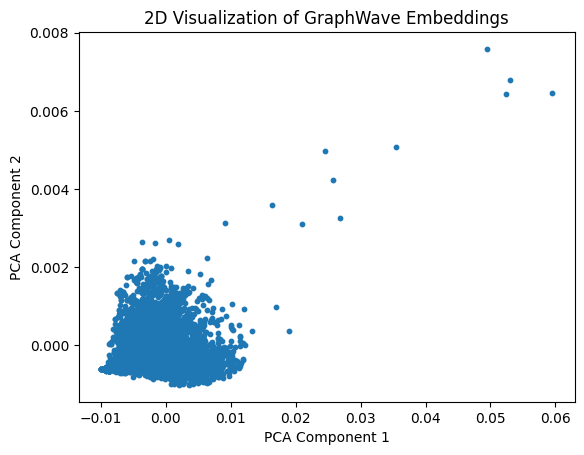

In [17]:


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
chi_2d = pca.fit_transform(chi)

# Plot the embeddings
plt.scatter(chi_2d[:, 0], chi_2d[:, 1], s=10)
plt.title("2D Visualization of GraphWave Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
print(f"Reconstruction error from matrix A: {reconstruction_error(G_facebook, chi)}")
plt.show()